In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from systems.Fields.scalar_field import Scalar_Field
from systems.Fields.phi4 import Phi4
from flows.NormalizingFlow import NormalizingFlow    
from lattice import Lattice
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('high')

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(42)


L = 16
latt = Lattice([L,L],[16,4],device=device)



sf = Scalar_Field(latt,1)
phi_4 = Phi4(latt,1,1/24)


sf.set_J_local(1,[0,L//2])
phi_4.set_J_local(1,[0,L//2])




In [4]:
normal_dist = latt.normal_sampler()
train_loader = latt.get_train_loader(epoch_size = 2**18,batch_size = 2 ** 14)

In [5]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        latent,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        
        super().__init__()
        self.model = model

        self.loss = criterion.to(device)
        self.latent = latent
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs
        
    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters(), **self.optimizer_kwargs)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-5,
            factor=0.99,
            mode = "min",
            patience = 2
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch.to(device)
        latent_log_prob = torch.sum(self.model.lattice.log_prob(z),-1)
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        ess = self.loss.ESS(latent_log_prob,log_abs_det)

        
        sch = self.lr_schedulers()
        sch.step(loss)
        self.log('train_loss', loss,prog_bar=True)
        self.log('ess',ess)
        self.log('mean_x',torch.mean(x))
        self.log('lr',sch.get_last_lr()[0])
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [6]:
set_random_seed(42)
nf = NormalizingFlow.config_and_init(n_blocks = 4,num_hidden = 6,hidden_dim = 2 * latt.total_nodes,lattice=latt,ort=True)
nf.save("./weights/field.pth") 

In [7]:
nf = NormalizingFlow.load_model("./weights/field.pth").to(device)

In [8]:
"""
set_random_seed(42)


pipeline = Pipeline(model = nf, 
                  latent = normal_dist ,
                  criterion = phi_4.get_KL(), 
                  optimizer_class=torch.optim.Adam,
                  optimizer_kwargs={"lr": 0.001,"weight_decay":0}).to(device)

trainer = pl.Trainer(
        max_epochs = 100,
        logger = TensorBoardLogger(save_dir=f"./logs/field"),
        num_sanity_val_steps = 0,
        log_every_n_steps = 1,
        enable_checkpointing = False,
        accumulate_grad_batches = 1)

#trainer.fit(model=pipeline, train_dataloaders = train_loader)
"""

'\nset_random_seed(42)\n\n\npipeline = Pipeline(model = nf, \n                  latent = normal_dist ,\n                  criterion = phi_4.get_KL(), \n                  optimizer_class=torch.optim.Adam,\n                  optimizer_kwargs={"lr": 0.001,"weight_decay":0}).to(device)\n\ntrainer = pl.Trainer(\n        max_epochs = 100,\n        logger = TensorBoardLogger(save_dir=f"./logs/field"),\n        num_sanity_val_steps = 0,\n        log_every_n_steps = 1,\n        enable_checkpointing = False,\n        accumulate_grad_batches = 1)\n\n#trainer.fit(model=pipeline, train_dataloaders = train_loader)\n'

In [ ]:
set_random_seed(42)
G = np.array([1,2,4,8])

for i in range(len(G)):
     
    phi_4 = Phi4(latt,1,G[i]/24)
    phi_4.set_J_local(1,[0,L//2])

    pipeline = Pipeline(model = nf, 
                  latent = normal_dist ,
                  criterion = phi_4.get_KL(), 
                  optimizer_class=torch.optim.Adam,
                  optimizer_kwargs={"lr": 0.001,"weight_decay":0.1}).to(device)

    trainer = pl.Trainer(
        max_epochs = 50,
        logger = TensorBoardLogger(save_dir=f"./logs/field"),
        num_sanity_val_steps = 0,
        log_every_n_steps = 1,
        enable_checkpointing = False,
        accumulate_grad_batches = 1)
    
   
    trainer.fit(model=pipeline, train_dataloaders = train_loader)
    nf.save("./weights/field"+str(G[i])+".pth")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | NormalizingFlow | 14.2 M | train
1 | loss  | KL_with_S       | 0      | train
--------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.943    Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode
/home/seva/Рабочий стол/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 49:   0%|          | 0/16 [00:00<?, ?it/s, v_num=2, train_loss=1.030]         


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
"""
try: 
    trainer.fit(model=pipeline, train_dataloaders = train_loader)
except Exception:
    nf.save("./weights/field.pth")
"""    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | NormalizingFlow | 14.2 M | train
1 | loss  | KL_with_S       | 0      | train
--------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.943    Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode


Epoch 88:  81%|████████▏ | 13/16 [00:07<00:01,  1.63it/s, v_num=62, train_loss=1.910]


Detected KeyboardInterrupt, attempting graceful shutdown ...


In [19]:
nf = NormalizingFlow.load_model("./weights/field.pth").to(device)
nf.eval()

NormalizingFlow(
  (flows): ModuleList(
    (0-7): 8 x AffineCouplingLayer(
      (theta): ThetaNetwork(
        (input): Linear(in_features=128, out_features=512, bias=True)
        (hidden): ModuleList(
          (0-5): 6 x Sequential(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Dropout(p=0, inplace=False)
            (2): LayerNorm((np.int64(512),), eps=1e-05, elementwise_affine=True)
          )
        )
        (dims): Linear(in_features=512, out_features=256, bias=True)
      )
    )
  )
)

In [ ]:
"""
z = normal_dist.sample((1000,)).to(device)
with torch.no_grad():
    phi, _ = nf.g(z)
err = torch.std(phi)    
phi = torch.mean(phi,0)

prop_x = sf.get_free_prop_x() 
phi_theor = -torch.matmul(prop_x,sf.J)
print(torch.mean(phi-phi_theor),err/(1000 ** 0.5))
"""


tensor(0.0047, device='cuda:0') tensor(0.0106, device='cuda:0')


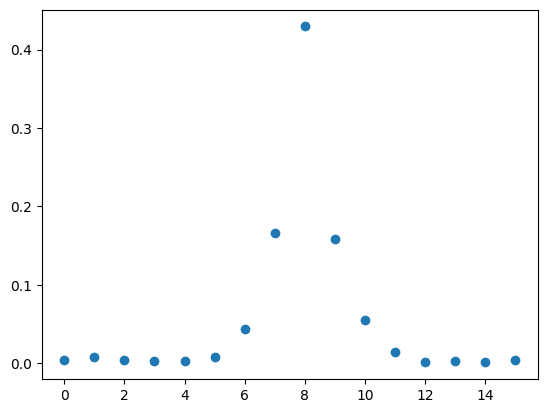

In [21]:
z = normal_dist.sample((100,)).to(device)
with torch.no_grad():
    phi, _ = nf.g(z)
phi = torch.mean(phi,0)

av = sf.lattice.get_time_averaging_mat()
phi = torch.matmul(av,phi)

plt.figure()
plt.scatter(np.arange(sf.lattice.n_nodes[1]),-phi.cpu())
plt.show()

In [ ]:
from samplers.Langevin import Langevin
from samplers.NN_Metropolis import NN_Metropolis

for i in range(len(G)):
    x = normal_dist.sample((1,)).to(device)

    N_samp=1000
    Lang = Langevin(phi_4,1,val = "none",eps = 0.001,N_sweep = 100,log_per = 1000,filename = "./trajs_and_corr/1.txt",open_mode = "w")
    nn_M = NN_Metropolis(phi_4,N_samp,nf,Lang,log_per = 1000,filename="trajs_and_corr/localJ"+str(G[i])+".txt",stat_filename="./trajs_and_corr/stat"+str(G[i])+".txt")
    nn_M.run(x)

tensor([[ 0.0202, -0.1825,  0.0769,  0.0510, -0.1090, -0.0068,  0.4105,  0.4959,
          0.2295, -0.0814, -0.2062, -0.3153,  0.0289,  0.5368, -0.0258,  0.2977,
         -0.2273, -0.1041,  0.3749,  0.2349,  0.3209, -0.4064,  0.1815,  0.2269,
          0.0437, -0.3166, -0.1353, -0.1645, -0.4408,  0.1646,  0.0084,  0.3763,
          0.1502,  0.3443, -0.1137,  0.3276, -0.3484, -0.1079,  0.3991,  0.2041,
         -0.1054, -0.1016, -0.2875,  0.2230,  0.0933,  0.4070,  0.6982,  0.1382,
          0.0804, -0.1666, -0.2198, -0.0647,  0.1910, -0.3718,  0.6844,  0.0999,
         -0.3933, -0.0402, -0.1242,  0.3569, -0.0986,  0.1322,  0.4264,  0.0957,
         -0.0664,  0.6489, -0.0421, -0.7392, -0.2130, -0.3945,  0.1252, -0.0541,
          0.1366,  0.7458, -0.1945, -0.1254,  0.3971,  0.7910,  0.1563, -0.1082,
         -0.3481,  0.5663,  0.1759, -0.0637, -0.4013, -0.3575, -0.1164,  0.4406,
         -0.1286,  0.1625, -0.0729,  0.0620,  0.1639,  0.2403, -0.0531, -0.0319,
         -0.1675,  0.1164,  

torch.Size([1000, 256])
torch.float32


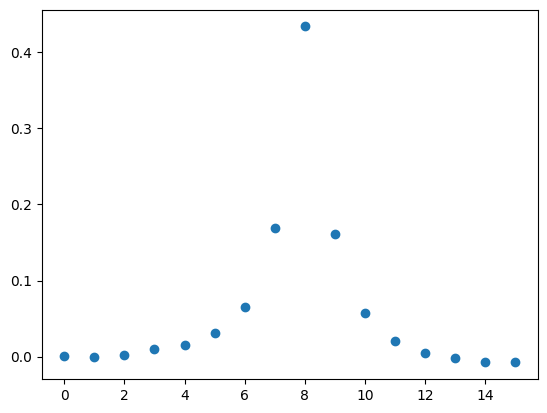

In [37]:
phi = np.genfromtxt("trajs_and_corr/0.txt",delimiter=" ")
phi = torch.tensor(phi).to(device).to(torch.float32)
print(phi.shape)


phi = torch.mean(phi,0)

av = sf.lattice.get_time_averaging_mat()
print(phi.dtype)
phi = torch.matmul(av,phi)

plt.figure()
plt.scatter(np.arange(sf.lattice.n_nodes[1]),-phi.cpu())
plt.show()
